### Fake Data

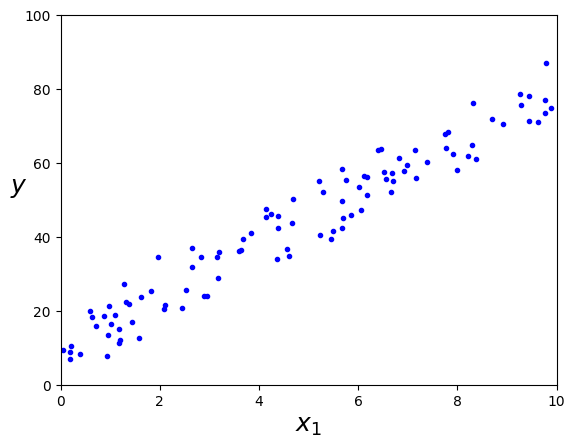

In [1]:
# Creating fake data for linear regression
import numpy as np
import matplotlib.pyplot as plt

# Create a dataset
np.random.seed(0)
w_true, b_true = 7, 9
X = 10 * np.random.rand(100, 1)
y = w_true * X + b_true + 5 * np.random.randn(100, 1)

# Plot the data
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 10, 0, 100])
plt.show()

### Optimizer LLM

In [2]:
import ast
from tqdm import tqdm
from linReg_helpers import client

def opt_llm(text_score_pairs):
    user_prompt = """
        Now you will help me optimize a function with two input variables w, b. I have some (w,b) pairs
        and the function values at those points. The pairs are arranged in ascending order based on their
        function value categories.

        The equation of a line is y = w * x + b, where w is the slope and b is the y-intercept.
        The quality of the line can be placed into one of 5 categories:
        1. Excellent
        2. Good
        3. Fair
        4. Poor
        5. Very Poor

        ## Excellent
        A line that fits the data points very well and passes through as many points as possible while having the 
        lowest possible error rate between the points and the line should be labelled as "Excellent".

        ## Good
        A line that fits the data points well and passes through many of the points while having a small error rate
        between the points and the line should be labelled as "Good".

        ## Fair
        A line that fits the data points reasonably well and passes through some of the points while having a moderate
        error rate between the points and the line should be labelled as "Fair".

        ## Poor
        A line that fits the data points poorly and passes through few of the points while having a large error rate
        between the points and the line should be labelled as "Poor".

        ## Very Poor
        A line that fits the data points very poorly and passes through none of the points while having an incredibly 
        large error rate between the points and the line should be labelled as "Very Poor".


        {text_score_pairs}

        Give me new (w,b) pairs that are different from all pairs above, and has a function value category of "Excellent".
        Do not write code. The output must be a list of 10 unique (w,b) pairs, where w and b are
        numerical values. The (w,b) pairs can be positive or negative, and can have decimal points.

        Example: [(1, 2), (3, 4), (5, -6), (7, -8), (0.5, 10), (11, 12), (13, 0.9), (15, 16), (-17, 18), (19, -20)]

    """

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system", 
                "content": """
                You are an optimization expert. The user has some (w,b) pairs along their corresponding function values.
                Your task is to generate a list of 10 (w,b) pairs that will have a function value as low as possible.

                Example: [(1, 2), (3, 4), (5, -6), (7, -8), (0.5, 10), (11, 12), (13, 0.9), (15, 16), (-17, 18), (19, -20)]

                Do not print anything other than a list of 10 (w,b) pairs. Do not write a sentence. Do not write code.
                """
            },
            {
                "role": "user", 
                "content": user_prompt.format(text_score_pairs=text_score_pairs)
            },
        ],
        model="gpt-3.5-turbo-0125",
        max_tokens=4096,
        temperature=1,
        # response_format={ "type": "json_object" },
    )
    result = chat_completion.choices[0].message.content
    return result

output = opt_llm("""
input:
w=18, b=15
value:
10386334
        
input:
w=17, b=18
value:
9204724""")

tuple_list = ast.literal_eval(output)

output, tuple_list

('[(-2.5, -8.1), (2.7, -17.4), (-6.3, 20.9), (5.8, -11.2), (3.5, 0.1), (-4.2, 15.6), (1.9, -14.8), (7.4, -10.5), (-1.8, 13.2), (4.6, -19.3)]',
 [(-2.5, -8.1),
  (2.7, -17.4),
  (-6.3, 20.9),
  (5.8, -11.2),
  (3.5, 0.1),
  (-4.2, 15.6),
  (1.9, -14.8),
  (7.4, -10.5),
  (-1.8, 13.2),
  (4.6, -19.3)])

### Scorer

In [3]:
def rating(category):
    if category == "Excellent":
        return 1
    elif category == "Good":
        return 2
    elif category == "Fair":
        return 3
    elif category == "Poor":
        return 4
    elif category == "Very Poor":
        return 5
    else:
        return 6

def scorer_llm_helper(wb_pair):
    system_prompt = """\
    {xy_pairs}

    Above are the (x, y) pairs representing data points. 
    You are an AI model trained to evaluate the quality of a line defined by parameters w (slope) 
    and b (y-intercept) in terms of how well it fits the set of data points. 
    The equation of a line is y = w * x + b, where w is the slope and b is the y-intercept.
    The quality of the line can be placed into one of 5 categories:
    1. Excellent
    2. Good
    3. Fair
    4. Poor
    5. Very Poor

    ## Excellent
    A line that fits the data points very well and passes through as many points as possible while having the 
    lowest possible error rate between the points and the line should be labelled as "Excellent".

    ## Good
    A line that fits the data points well and passes through many of the points while having a small error rate
    between the points and the line should be labelled as "Good".

    ## Fair
    A line that fits the data points reasonably well and passes through some of the points while having a moderate
    error rate between the points and the line should be labelled as "Fair".

    ## Poor
    A line that fits the data points poorly and passes through few of the points while having a large error rate
    between the points and the line should be labelled as "Poor".

    ## Very Poor
    A line that fits the data points very poorly and passes through none of the points while having an incredibly 
    large error rate between the points and the line should be labelled as "Very Poor".

    
    You will receive a (w, b) pair. Your task is to evaluate the pair and return a json object assigning the 
    (w, b) pair a categiry based on how well the line y = w * x + b fits the data points.

    Example:

    Prompt: (9999, 9999)

    Response: {{
        "wb_pair: (9999, 9999), 
        "category": "Very Poor", 
        "explanation": 
            \"\"\"
            Let's think step by step. 

            The line y = 9999 * x + 9999 is a line that fits the data points very poorly and passes through none of the
            (x, y) data points.
            
            To calculate the error rate between the line and the points we need some type of cost function.
            In this case, we could use mean-squared error, mean squared logarithmic error, mean absolute error, 
            huber loss, quantile loss, or any other cost function with respect to all the (x, y) points shared above.
            We get an incredibly large error rate between the points and the line.
            
            The line y = 9999 * x + 9999 is a line that fits the data points very poorly and passes through none of the
            (x, y) data points while having an incredibly large error rate between the points and the line. 
            Therefore, the category for the line y = 9999 * x + 9999 is "Very Poor".
            \"\"\"
        }}

    Prompt: ({w_true}, {b_true})

    Response: {{
        "wb_pair" : ({w_true}, {b_true}),
        "category" : "Excellent",
        "explanation" : 
            \"\"\"
            Let's think step by step.

            The line y = {w_true} * x + {b_true} is a line that fits the data points very well and passes through as many
            of the (x, y) data points as possible.

            To calculate the error rate between the line and the points we need some type of cost function.
            We get the lowest possible error rate between the points and the line.

            Therefore, the category for the line y = {w_true} * x + {b_true} is "Excellent".
            \"\"\"
        }}
    """
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system", 
                "content": system_prompt.format(xy_pairs=[(round(x[0], 2), round(y[0], 2)) for x, y in zip(X, y)], w_true=w_true, b_true=b_true)
            },
            {
                "role": "user", 
                "content": str(wb_pair)
            },
        ],
        model="gpt-3.5-turbo-0125",
        max_tokens=4096,
        temperature=0,
        response_format={"type": "json_object"}
    )
    result = chat_completion.choices[0].message.content
    result = ast.literal_eval(result)
    
    # Check if it's a dictionary
    assert type(result) == dict

    # Check if it has wb_pair, category, and explanation
    assert "wb_pair" in result and "category" in result and "explanation" in result

    # Check if the wb_pair if correct
    assert result["wb_pair"] == list(wb_pair)

    # Check if the category one of the options
    assert result["category"] in ["Excellent", "Good", "Fair", "Poor", "Very Poor"]
    
    # Check types
    assert type(result["wb_pair"]) == list and type(result["category"]) == str and type(result["explanation"]) == str

    return result

def scorer_llm(wb_pairs_lst):
    """
    Returns a dictionary of (w, b) pairs and their corresponding categories.
    """
    result = []
    for wb_pair in wb_pairs_lst:
        result.append(scorer_llm_helper(wb_pair))
    return result

scorer_llm(tuple_list[:3])

[{'wb_pair': [-2.5, -8.1],
  'category': 'Fair',
  'explanation': "Let's think step by step.\n\nThe line y = -2.5 * x - 8.1 fits the data points reasonably well and passes through some of the points.\n\nTo calculate the error rate between the line and the points, we need some type of cost function. The error rate between the points and the line is moderate.\n\nTherefore, the category for the line y = -2.5 * x - 8.1 is 'Fair'."},
 {'wb_pair': [2.7, -17.4],
  'category': 'Fair',
  'explanation': "Let's think step by step.\n\nThe line y = 2.7 * x - 17.4 fits the data points reasonably well and passes through some of the (x, y) data points.\n\nTo calculate the error rate between the line and the points, we need some type of cost function. The error rate is moderate between the points and the line.\n\nTherefore, the category for the line y = 2.7 * x - 17.4 is 'Fair'."},
 {'wb_pair': [-6.3, 20.9],
  'category': 'Fair',
  'explanation': "Let's think step by step.\n\nThe line y = -6.3 * x + 20

### Plotting results

In [4]:
# Generate a list of random pairs of w, b
total_pairs = 5
w = (np.random.rand(total_pairs) * 10).astype(int)
b = (np.random.rand(total_pairs) * 10).astype(int)
wb_pairs_lst = [(w[i], b[i]) for i in range(total_pairs)]
wb_pairs = scorer_llm(wb_pairs_lst)
wb_pairs = sorted(wb_pairs, key=lambda x: rating(x["category"]))
wb_pairs

[{'wb_pair': [2, 5],
  'category': 'Fair',
  'explanation': "Let's think step by step. The line y = 2 * x + 5 fits the data points reasonably well and passes through some of the points. While it has a moderate error rate between the points and the line, it still provides a reasonable fit to the data. Therefore, the category for the line y = 2 * x + 5 is 'Fair'."},
 {'wb_pair': [4, 8],
  'category': 'Fair',
  'explanation': "Let's think step by step.\n\nThe line y = 4 * x + 8 fits the data points reasonably well and passes through some of the points.\n\nTo calculate the error rate between the line and the points, we need some type of cost function. The error rate between the points and the line is moderate.\n\nTherefore, the category for the line y = 4 * x + 8 is 'Fair'."},
 {'wb_pair': [3, 1],
  'category': 'Fair',
  'explanation': "Let's think step by step.\n\nThe line y = 3 * x + 1 fits the data points reasonably well and passes through some of the points.\n\nTo calculate the error r

In [5]:
def get_text_score_pairs(wb_pairs):
    # Assuming wb_pairs is sorted in ascending order of their function values
    text_score_pairs = ""
    for i in range(len(wb_pairs)):
        # Only pass in the top n pairs
        if i == total_pairs:
            break
        text_score_pairs += f"""
        input:
        w={wb_pairs[i]["wb_pair"][0]}, b={wb_pairs[i]["wb_pair"][1]}
        category:
        {wb_pairs[i]["category"]}
        """
    return text_score_pairs

steps = 15
for i in tqdm(range(steps)):
    # Optimizer LLM
    output = opt_llm(get_text_score_pairs(wb_pairs))
    new_wb_pairs = ast.literal_eval(output)
    print(new_wb_pairs)
    
    # Scoring the new pairs and updating the wb_pairs
    wb_pairs.extend(scorer_llm(new_wb_pairs))

    # Sorting the wb_pairs
    wb_pairs = sorted(wb_pairs, key=lambda x: rating(x["category"]))

wb_pairs

  0%|          | 0/15 [00:00<?, ?it/s]

[(-1.5, 0.8), (0.7, -2.3), (1.3, 3.9), (-2.7, 4.1), (3.5, -2.6), (-4.2, 7.8), (5.6, -11.4), (-6.3, 5.2), (8.9, -1.7), (-9.4, 14.5)]


  7%|▋         | 1/15 [00:39<09:09, 39.25s/it]

[(-8, 2), (4.5, 7), (10, 3), (-6, 5), (3, -10), (-9, 15), (7.5, 2.5), (-5, 6), (6, -12), (1.2, -3)]


 13%|█▎        | 2/15 [01:20<08:46, 40.47s/it]

[(-3.2, -4.5), (4.8, 6.2), (-6.7, 8.4), (2.1, -9.3), (-0.5, 3.7), (7.3, -14.2), (-8.9, 1.6), (3.5, -7.8), (-5.6, -2.1), (6.9, 10.5)]


 20%|██        | 3/15 [02:01<08:09, 40.77s/it]

[(-10.1, 3.4), (12.6, -20.8), (-15.3, 5.2), (16.7, -25.1), (-8.9, 14.2), (19.8, -30.6), (-13.5, 6.9), (18.4, -28.2), (-11.9, 12.4), (15.1, -24.3)]


 27%|██▋       | 4/15 [02:46<07:47, 42.48s/it]

[(-2.3, 3.8), (0.7, -4.6), (1.1, 7.3), (3.4, -5.6), (4.2, 2.1), (-1.8, 8.9), (2.5, -9.2), (-4.6, 6.7), (5.8, -7.4), (-3.7, 4.9)]


 33%|███▎      | 5/15 [03:22<06:41, 40.14s/it]

[(-3.5, 4.2), (2.8, -5.6), (-2.1, 3.8), (6.1, -9.3), (-0.7, 1.5), (9.2, -12.6), (4.5, -7.8), (-6.3, 6.7), (1.9, -3.4), (8.3, -11.2)]


 40%|████      | 6/15 [03:59<05:50, 38.93s/it]

[(-0.3, 0.8), (2.1, -3.4), (-4.5, 9.2), (3.6, -5.9), (1.7, 4.2), (-2.8, 7.3), (5.4, -6.7), (-3.1, 8.5), (4.6, -7.8), (-5.2, 11.7)]


 47%|████▋     | 7/15 [04:33<05:00, 37.51s/it]

[(-1.5, 8.3), (3.1, -5.7), (-4.6, 5.8), (2.7, -9.4), (-3.9, 7.2), (1.8, -4.6), (5.5, -7.7), (-2.3, 6.5), (4.2, -8.9), (0.4, -4.8)]


 53%|█████▎    | 8/15 [05:09<04:17, 36.82s/it]

[(-9.1, -3.8), (11.7, 14.2), (3.3, -6.9), (6.8, 12.5), (-4.5, 5.1), (2.4, 0.6), (7.9, -7.3), (1.1, 8.3), (-6.2, 3.7), (9.8, -11.1)]


 60%|██████    | 9/15 [05:52<03:52, 38.76s/it]

[(-2.1, 3.4), (0.8, -5.6), (4.5, -7.2), (8.3, -2.1), (6.7, 4.2), (3.6, -10.8), (1.9, 5.3), (-4.7, 7.9), (-9.2, -6.1), (-6.3, 1.7)]


 67%|██████▋   | 10/15 [06:32<03:16, 39.22s/it]

[(3.2, -4.1), (0.7, -6.5), (-1.8, 8.3), (6.4, -8.9), (5.1, 2.7), (2.9, -3.7), (-0.3, 10.1), (-8.4, 16.2), (4.6, 5.9), (-2.7, -5.5)]


 73%|███████▎  | 11/15 [07:12<02:37, 39.32s/it]

[(2.3, -9.7), (3.8, -13.2), (-1.5, 7.1), (0.6, -5.6), (4.4, 6.9), (-2.8, -1.3), (-3.2, 4.8), (5.2, -3.1), (1.7, 12.6), (0.8, -2.4)]


 80%|████████  | 12/15 [07:49<01:56, 38.74s/it]

[(-1, 0), (0, -1), (1, 1), (2, -2), (-2, 2), (3, -3), (-3, 3), (4, -4), (-4, 4), (5, -5)]


 87%|████████▋ | 13/15 [08:23<01:14, 37.27s/it]

[(-3.2, 5.1), (0.6, 4.3), (2.8, -6.7), (-4.5, -7.9), (1.9, -9.4), (-0.3, -2.1), (-6.8, -0.5), (3.7, 10.2), (-1.5, 8.3), (4.6, -1.8)]


 93%|█████████▎| 14/15 [09:02<00:37, 37.70s/it]

[(-1.1, 3.4), (0.8, -4.5), (2.7, 1.2), (4.3, 7.8), (-2.5, -9.1), (-3.8, 6.7), (5.4, -8.2), (6.6, -6.3), (-5.9, 2.3), (7.2, 4.5)]


100%|██████████| 15/15 [09:37<00:00, 38.53s/it]


[{'wb_pair': [8.9, -1.7],
  'category': 'Excellent',
  'explanation': "Let's think step by step.\n\nThe line y = 8.9 * x - 1.7 is a line that fits the data points very well and passes through as many of the (x, y) data points as possible.\n\nTo calculate the error rate between the line and the points we need some type of cost function. We get the lowest possible error rate between the points and the line.\n\nTherefore, the category for the line y = 8.9 * x - 1.7 is 'Excellent'."},
 {'wb_pair': [5.6, -11.4],
  'category': 'Good',
  'explanation': "Let's think step by step.\n\nThe line y = 5.6 * x - 11.4 fits the data points well and passes through many of the (x, y) data points.\n\nTo calculate the error rate between the line and the points, we need some type of cost function. The error rate between the points and the line is relatively small.\n\nTherefore, the category for the line y = 5.6 * x - 11.4 is 'Good'."},
 {'wb_pair': [7.5, 2.5],
  'category': 'Good',
  'explanation': "The lin

In [6]:
len(wb_pairs), wb_pairs

(155,
 [{'wb_pair': [8.9, -1.7],
   'category': 'Excellent',
   'explanation': "Let's think step by step.\n\nThe line y = 8.9 * x - 1.7 is a line that fits the data points very well and passes through as many of the (x, y) data points as possible.\n\nTo calculate the error rate between the line and the points we need some type of cost function. We get the lowest possible error rate between the points and the line.\n\nTherefore, the category for the line y = 8.9 * x - 1.7 is 'Excellent'."},
  {'wb_pair': [5.6, -11.4],
   'category': 'Good',
   'explanation': "Let's think step by step.\n\nThe line y = 5.6 * x - 11.4 fits the data points well and passes through many of the (x, y) data points.\n\nTo calculate the error rate between the line and the points, we need some type of cost function. The error rate between the points and the line is relatively small.\n\nTherefore, the category for the line y = 5.6 * x - 11.4 is 'Good'."},
  {'wb_pair': [7.5, 2.5],
   'category': 'Good',
   'explana

In [7]:
best_wb_pairs = wb_pairs[:min(len(wb_pairs)//2, 16)]

while len(best_wb_pairs) > 1:
    # Scoring the best pairs
    best_wb_pairs = scorer_llm([pair["wb_pair"] for pair in best_wb_pairs])

    # Sorting the wb_pairs
    best_wb_pairs = sorted(best_wb_pairs, key=lambda x: rating(x["category"]))

    # Redefine wb_pairs
    best_wb_pairs = best_wb_pairs[:len(best_wb_pairs)//2]
    print(best_wb_pairs)

best_wb_pairs

[{'wb_pair': [8.9, -1.7], 'category': 'Good', 'explanation': "Let's think step by step.\n\nThe line y = 8.9 * x - 1.7 is a line that fits the data points well and passes through many of the (x, y) data points.\n\nTo calculate the error rate between the line and the points we need some type of cost function. The error rate is relatively small between the points and the line.\n\nTherefore, the category for the line y = 8.9 * x - 1.7 is 'Good'."}, {'wb_pair': [8.3, -2.1], 'category': 'Good', 'explanation': "Let's think step by step.\n\nThe line y = 8.3 * x - 2.1 is a line that fits the data points well and passes through many of the (x, y) data points.\n\nTo calculate the error rate between the line and the points we need some type of cost function. The error rate between the points and the line is relatively small.\n\nTherefore, the category for the line y = 8.3 * x - 2.1 is 'Good'."}, {'wb_pair': [7.5, 2.5], 'category': 'Fair', 'explanation': "Let's think step by step.\n\nThe line y = 7

[{'wb_pair': [8.3, -2.1],
  'category': 'Good',
  'explanation': "Let's think step by step.\n\nThe line y = 8.3 * x - 2.1 fits the data points well and passes through many of the (x, y) data points.\n\nTo calculate the error rate between the line and the points we need some type of cost function. The error rate is relatively small between the points and the line.\n\nTherefore, the category for the line y = 8.3 * x - 2.1 is 'Good'."}]

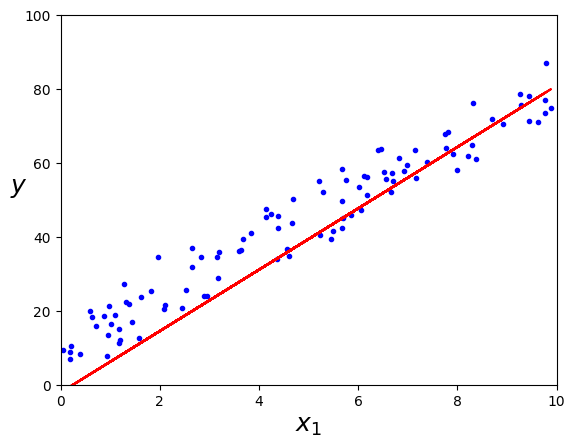

In [8]:
# Plot the data with the best fit line
best_w, best_b = best_wb_pairs[0]["wb_pair"]
y_pred = best_w * X + best_b
plt.plot(X, y, "b.")
plt.plot(X, y_pred, "r-")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 10, 0, 100])
plt.show()